# MPS and MPO operations with ITensor

In [1]:
using ITensors
using Plots
using HDF5

Create some MPSs

In [2]:
# Create MPS from ITensor or from Julia array
i = Index(2)
j = Index(2)
k = Index(2)
l = Index(2)
m = Index(2)

cutoff = 1E-20
maxdim = 10
T = randomITensor(i,j,k,l,m) # From ITensor
#T = randn(2^5); # From Julia array
ψ0 = MPS(T,(i,j,k,l,m);cutoff=cutoff,maxdim=maxdim)

ψ0cont = contract(ψ0); # Recover (reshaped) entry matrix

@show ψ0;

ψ0 = MPS
[1] ((dim=2|id=571), (dim=2|id=58|"Link,n=1"))
[2] ((dim=2|id=58|"Link,n=1"), (dim=2|id=600), (dim=4|id=643|"Link,n=2"))
[3] ((dim=4|id=643|"Link,n=2"), (dim=2|id=809), (dim=4|id=126|"Link,n=3"))
[4] ((dim=4|id=126|"Link,n=3"), (dim=2|id=136), (dim=2|id=24|"Link,n=4"))
[5] ((dim=2|id=24|"Link,n=4"), (dim=2|id=554))



In [3]:
N = 10; # Number of sites
s = siteinds("Qubit", N); # Indices for all sites
#s = siteinds("Qubit", N, conserve_qns = true); 
#s = siteinds("Qubit", N, conserve_qns = false);

In [4]:
# Create by hand MPS with desired order

ψ1_list = ["0" for n=1:N]; # Magnetization 1 (up) everywhere
ψ1 = MPS(s,ψ1_list);

ψ2 = randomMPS(s,linkdims=10);
ψ2 = orthogonalize!(ψ2, N);

ψ3_list = [isodd(n) ? "1" : "0" for n in 1:N]; # Magnetization 1 (up) and -1 (down) interleaved
ψ3 = MPS(ComplexF64, s, ψ3_list);

@show ψ3_list;

ψ3_list = ["1", "0", "1", "0", "1", "0", "1", "0", "1", "0"]


In [5]:
@show maxlinkdim(ψ1);
@show maxlinkdim(ψ2);
@show maxlinkdim(ψ3);

maxlinkdim(ψ1) = 1
maxlinkdim(ψ2) = 10
maxlinkdim(ψ3) = 1


In [6]:
@show norm(ψ1), norm(ψ2), norm(ψ3);

(norm(ψ1), norm(ψ2), norm(ψ3)) = (1.0, 1.0, 1.0)


Addition of MPSs

In [7]:
ψ4 = ψ2 + ψ3; # A cutoff of 1e-15 is used by default
ψ5 = +(ψ1, ψ3; cutoff = 1e-8); # Set the cutoff

In [8]:
@show norm(ψ4), norm(ψ5);

(norm(ψ4), norm(ψ5)) = (1.409605314830854, 1.4142135623730951)


In [9]:
normalize!(ψ4); # Use ! so state is replaced by normalized one (in-place operation, where memory of output is preallocated)
ψ5 = normalize(ψ5); # Or set A = normalize(B)

In [10]:
@show linkdims(ψ2);
@show linkdims(ψ3);
@show linkdims(ψ4);

linkdims(ψ2) = [2, 4, 8, 10, 10, 10, 8, 4, 2]
linkdims(ψ3) = [1, 1, 1, 1, 1, 1, 1, 1, 1]
linkdims(ψ4) = [3, 5, 9, 11, 11, 11, 8, 4, 2]


In [11]:
@show linkdims(ψ1);
@show linkdims(ψ3);
@show linkdims(ψ5);

linkdims(ψ1) = [1, 1, 1, 1, 1, 1, 1, 1, 1]
linkdims(ψ3) = [1, 1, 1, 1, 1, 1, 1, 1, 1]
linkdims(ψ5) = [2, 2, 2, 2, 2, 2, 2, 2, 1]


Truncate states

In [12]:
ψ4 = truncate(ψ4, cutoff = 1e-1);
@show linkdims(ψ4);

linkdims(ψ4) = [1, 1, 1, 2, 3, 4, 4, 3, 2]


In [13]:
truncate!(ψ5, maxdim = 1); # Check what happens when maxdim = 1!
@show linkdims(ψ5);

linkdims(ψ5) = [1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
# Adding a state with itself

ψ11 = ψ1 + ψ1;
@show linkdims(ψ11); # Automatically truncated
@show norm(ψ11); # But not normalized
normalize!(ψ11);

linkdims(ψ11) = [1, 1, 1, 1, 1, 1, 1, 1, 1]
norm(ψ11) = 2.0


Overlap of MPSs

In [15]:
dot(ψ1,ψ3)

0.0 + 0.0im

In [16]:
inner(ψ5,ψ3) # Check the impact when ψ5 was truncated with maxdim = 1

0.0 + 0.0im

In [17]:
dot(ψ1,ψ11)

1.0

Apply single-site operator to an MPS

In [18]:
site = 3;
@show ψ1[site];

ψ1[site] = ITensor ord=3
Dim 1: (dim=1|id=874|"Link,l=2")
Dim 2: (dim=2|id=87|"Qubit,Site,n=3")
Dim 3: (dim=1|id=888|"Link,l=3")
NDTensors.Dense{Float64, Vector{Float64}}
 1×2×1
[:, :, 1] =
 1.0  0.0


In [19]:
ψ1 = apply(op("H",s[site]),ψ1); # Use Hadamard gate, which creates equal superposition of 0 and 1 
@show ψ1[site];

ψ1[site] = ITensor ord=3
Dim 1: (dim=2|id=87|"Qubit,Site,n=3")
Dim 2: (dim=1|id=915|"Link,l=2")
Dim 3: (dim=1|id=101|"Link,l=3")
NDTensors.Dense{Float64, Vector{Float64}}
 2×1×1
[:, :, 1] =
 0.7071067811865475
 0.7071067811865475


Apply two-site operator to an MPS

In [20]:
# First define two-site operator
site1 = 2; site2 = 3;

Oper = op("SWAP",s[site1],s[site2]);
#Oper = op("S-",s[site1])*op("S+",s[site2]);

In [21]:
orthogonalize!(ψ1,site1) # Set orthogonality center between sites 2 and 3, so other sites are correctly normalized and can be left out

wf = (ψ1[site1] * ψ1[site2]) * Oper # Multiply operator with MPS
noprime!(wf) # Remove primes of result

# Truncate after product to recover MPS structure
inds3 = uniqueinds(ψ1[site1],ψ1[site2]) # Finds indices unique to ψ1[site1]
U,S,V = svd(wf,inds3,cutoff=1E-12) # These indices will go into U when the SVD is done
ψ1[site1] = U;
ψ1[site2] = S*V;

Hadamard product

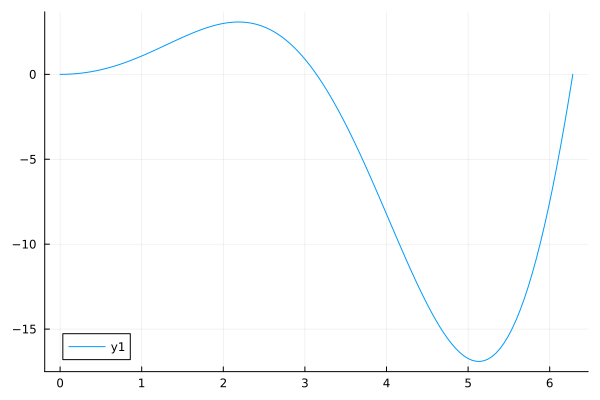

In [22]:
# Define two functions and their product
N = 7; # Number of sites
s = siteinds("Qubit", N); # Indices for all sites
xs = range(0, 2pi, length=2^N); # Sampling grid points

f1(x) = sin(x); # First function
ys1 = f1.(xs); # Construction f1(x)

f2(x) = x*exp(0.25*x); # Second function
ys2 = f2.(xs); # Construction f2(x)

f3(x) = f1(x)*f2(x);
ys3 = f3.(xs); # Construction f3(x)

plot(xs, ys3) # Plotting the original function

Encode the functions and their product as MPS

In [23]:
cutoff = 1E-16;
χ = 30;

ψ1 = MPS(ys1, s, cutoff=cutoff, maxdim=χ);
ψ2 = MPS(ys2, s, cutoff=cutoff, maxdim=χ);
ψ3 = MPS(ys3, s, cutoff=cutoff, maxdim=χ);

@show linkdims(ψ1);
@show linkdims(ψ2);
@show linkdims(ψ3);

linkdims(ψ1) = [2, 2, 2, 2, 2, 2]
linkdims(ψ2) = [2, 2, 2, 2, 2, 2]
linkdims(ψ3) = [2, 4, 4, 4, 4, 2]


Perform Hadamard product of the MPS of the two functions

In [24]:
had = MPO(N)
had .= convert(MPO, ψ1)
for i = 1:N
    had[i] *= δ(s[i], s[i]', s[i]'')
end

had = replaceprime(had, 2 => 0)

ψ3_Had = apply(had, ψ2; maxdim=maxdim)

@show linkdims(ψ3_Had);

linkdims(ψ3_Had) = [2, 4, 4, 4, 4, 2]


Contract the resulting MPS and plot the result

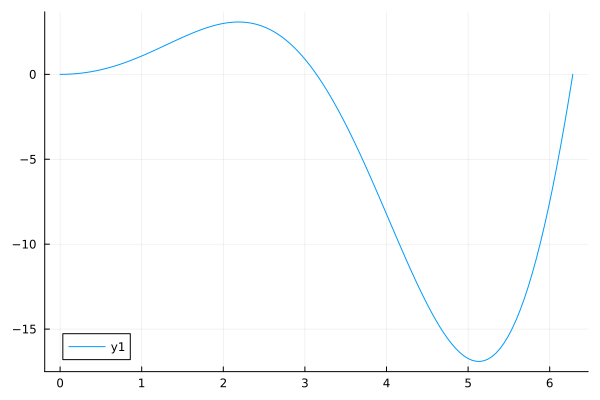

In [25]:
Big_ψ = contract(ψ3_Had) # Recovering the original big tensor
J_recon = Array(Big_ψ, s) # Changing the format from ITensor to Julia array for plotting
ys_recon = reshape(J_recon,2^N,1) # Reshaping from N-dimentional tensor to regular array
plot(xs, ys_recon) # Plotting the reconstructed function

Exercise finished!!!